## Análisis de los datos

### Carga de librerías y del conjunto de datos

Importamos las librerías necesarias:

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from scipy.stats import levene, shapiro, ttest_ind, ttest_rel
from statsmodels.graphics.gofplots import qqplot

Cargamos los datos limpiados:

In [2]:
dataset = pd.read_parquet("../data/madrid-rent-prices_4-8_cleaned.parquet")
dataset.head()

,zipCode,buildingSubtype,clientTypeId,dateOriginal,bathrooms,balcony,air_conditioner,heater,heating,swimming_pool,...,isHighlighted,isPackPremiumPriority,isNewConstruction,isOpportunity,otherFeaturesCount,price,periodicityId,price_var,publishedDays,target
index,,,,,,,,,,,,,,,,,,,,,
6,28027,Flat,Inmob.,2022-04-04,2,0,1,0,0,0,...,False,True,False,False,3,1320.0,Mensual,0,NaT,False
7,28045,Flat,Inmob.,2022-04-04,2,0,0,0,0,0,...,False,True,False,False,3,1190.0,Mensual,0,3 days 00:49:10.655000,False
22,28010,Flat,Inmob.,2022-04-04,2,0,1,1,0,0,...,False,True,False,False,6,2100.0,Mensual,0,0 days 15:13:14.955000,True
23,28033,SemiDetached,Inmob.,2022-04-04,2,0,1,1,0,0,...,False,True,False,False,7,2000.0,Mensual,0,NaT,False
24,28001,Flat,Inmob.,2022-04-04,2,1,1,1,0,0,...,False,True,False,False,5,3300.0,Mensual,0,NaT,False


### Análisis

Lo primero que hacemos es definir una función que usaremos, y cuyo fin será mostrar las representaciones visuales para comprobar si los datos siguen una distribución normal:

In [3]:
def visualizeNorm(title_fig, data):
    plt.figure(figsize=(12,6))
    plt.suptitle(title_fig, fontsize=20)

    ax1 = plt.subplot(1,2,1)
    sns.histplot(x=data, kde=True, ax=ax1, line_kws= {'color':'red','linestyle': 'dashed'},)
    ax1.lines[0].set_color('crimson')
    ax1.set_title('Histogram')
    ax1.set_xlabel('Value bin')
    ax1.set_ylabel('Frequency')

    ax2 = plt.subplot(1,2,2)
    qqplot(data, line='s', ax=ax2)
    ax2.set_title('QQ Plot')

    plt.show()

También realizamos una función que nos aplique el test de Levene sobre dos conjuntos de datos y compruebe si estos tienen iguales varianzas o no:

In [4]:
def showLeveneResult(data1, data2):
    stat, p_value = levene(data1, data2)
    print('Statistics=%.3f, p=%.3f' % (stat, p_value))
    alpha = 0.05
    if p_value > alpha:
        print('Equal variances')
    else:
        print('Unequal variances')

    print()

Y finalmente, otra que nos muestre si aplicando el test de Shapiro-Wilk, la cual evalúa una muestra si los datos siguen una distribución gaussiana:

In [5]:
def showShapiroWilkResult(data):
    stat, p_value = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p_value))

    alpha = 0.05
    if p_value > alpha:
        print('Gaussian Distributin')
    else:
        print('Non Gaussian Distribution')

    print()

#### Particulares vs Inmobiliarias

El primero de los análisis a llevar a cabo trata de ver si es más barato los inmuebles publicitados por particulares individualmente o por inmobiliaria. Dividimos los conjuntos y comprobamos su normalidad:

In [6]:
pd.unique(dataset.clientTypeId)

['Inmob.', 'Part.']
Categories (2, object): ['Part.', 'Inmob.']

In [7]:
datasetParti = dataset[dataset.clientTypeId == "Inmob."]
datasetInmob = dataset[dataset.clientTypeId == "Part."]

supMostrando las representaciones visuales de ambos conjuntos de precios:

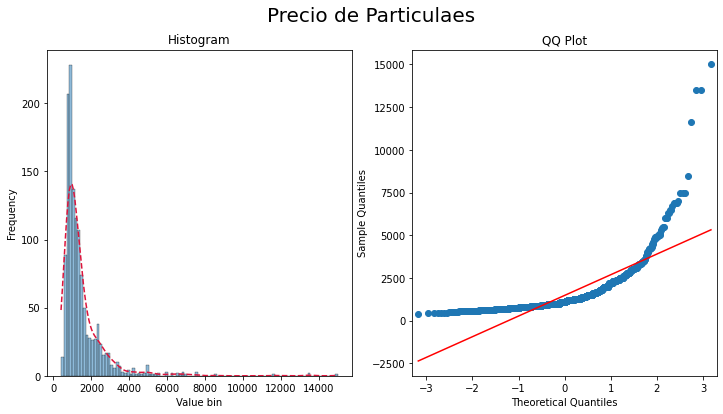

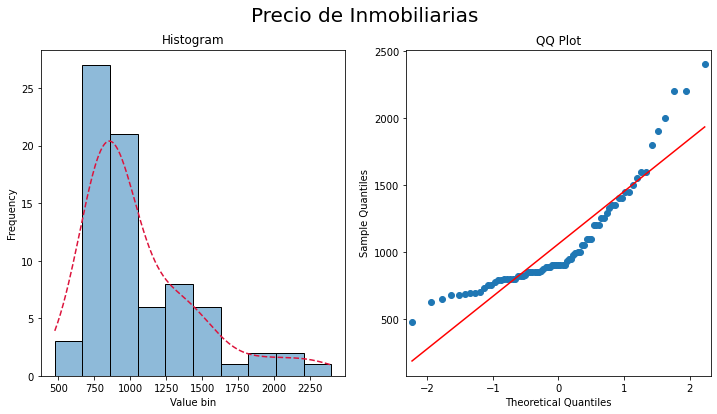

In [8]:
visualizeNorm('Precio de Particulaes', datasetParti.price)
visualizeNorm('Precio de Inmobiliarias', datasetInmob.price)

Como se puede apreciar no sé puede visualmente definir su distribución como normal. Si aplicamos el test de Shapiro-Wilk:

In [9]:
showShapiroWilkResult(datasetParti.price)
showShapiroWilkResult(datasetInmob.price)

Statistics=0.607, p=0.000
Non Gaussian Distribution

Statistics=0.843, p=0.000
Non Gaussian Distribution



Vemos que nos refleja que ninguna de las dos sigue una distribución gaussiana. Observando el número de elementos existentes:

In [10]:
print(len(datasetParti.price))
print(len(datasetInmob.price))

1329
77


A pesar de los resultados, como el conjunto de datos se compone de un número de registros suficientemente grande se puede aplicar el _teorema central del límite_ considerando que las medias muestrales siguen una distribución normal.

Para comprobar si existe alguna diferencia entre los precios de los anuncios de particulares y las de inmobiliaria, planteamos el siguiente contraste de hipótesis de dos muestras:


H0 : _μ1_ = _μ2_

H1 : _μ1_ < _μ2_


Donde _μ1_ es la media del precio de los inmuebles publicitados por particulares y μ2 es la media de los inmuebles publicitados por inmobiliaria. Pero antes de proseguir comprobamos si las varianzas desconocidas de la población son iguales o no:

In [11]:
showLeveneResult(datasetParti.price, datasetInmob.price)

Statistics=9.020, p=0.003
Unequal variances



En este caso vemos que se rechaza la hipótesis nula ya que es inferior a 0.05, por lo que los grupos tienen varianzas desiguales. Ahora aplicamos el test de Welch’s t-test al establecer el paramétro _equal_var_ a _False_ y comprobar si existe alguna diferencia entre los precios.

In [12]:
ttest_ind(a=datasetParti.price, b=datasetInmob.price, equal_var=False)

Ttest_indResult(statistic=7.555778020685704, pvalue=2.0838607169209693e-12)

Vemos como no se puede  rechazar la hipótesis nula, ya que el p-value es mayor que el nivel de significancia 0.05, con lo que se concluye que no hay una diferencia significativa entre los inmuebles según quién lo publicita.

#### Anuncios Promocionados, ¿sí o no?

El segundo de los análisis es ver si existe una diferencia de precios en los anuncios que utilizan el algún tipo de promoción:

* _isHighlighted_
* _isPackPremiumPriority_
* _isOpportunity_

Para ello unirmos estas características en una nueva llamada _promotion_ y realizaremos un contraste de hipótesis sobre las medias de los conjuntos definidos por esta nueva variable.


In [13]:
dataset['promotion'] = dataset['isHighlighted'] | dataset['isPackPremiumPriority'] | dataset['isOpportunity']

In [14]:
pd.unique(dataset.promotion)

array([ True, False])

In [15]:
datasetPack = dataset[dataset.promotion == True]
datasetNoPack = dataset[dataset.promotion == False]

Mostramos las representaciones visuales de ambos conjuntos de precios:

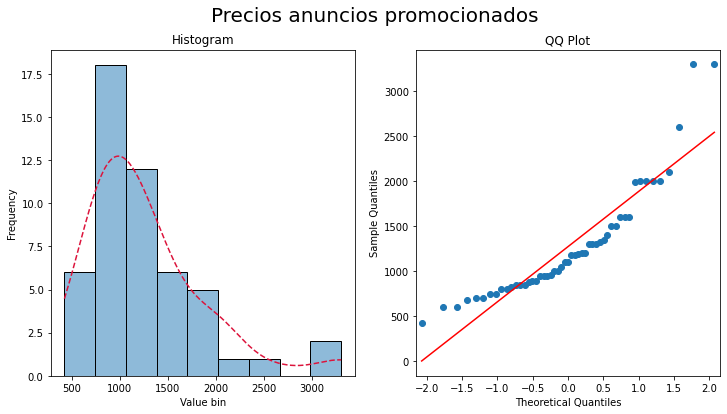

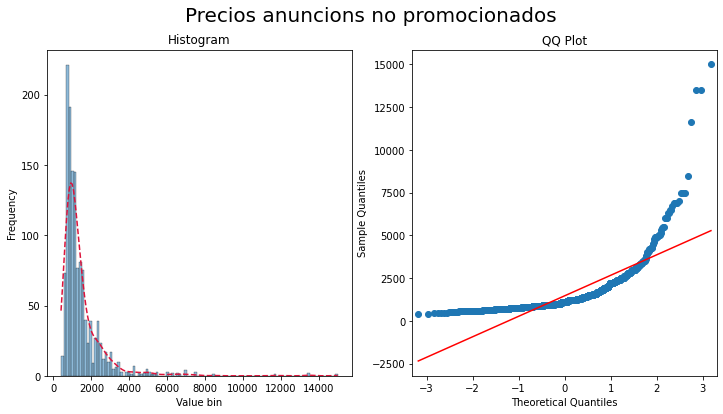

In [16]:
visualizeNorm('Precios anuncios promocionados', datasetPack.price)
visualizeNorm('Precios anuncions no promocionados', datasetNoPack.price)

Vemos que tenemos un comportamiento similar al caso anterior y visualmente no se ve que sigan una distribución normal. A nivel del test Shapiro-Wilk:

In [17]:
showShapiroWilkResult(datasetPack.price)
showShapiroWilkResult(datasetNoPack.price)

Statistics=0.849, p=0.000
Non Gaussian Distribution

Statistics=0.601, p=0.000
Non Gaussian Distribution



Vemos que ocurre como en el caso anterior y corrobora lo que se ve en la visualización, no siguen una distribución gaussiana. Observando el número de registros de cada conjunto:





In [18]:
print(len(datasetPack.price))
print(len(datasetNoPack.price))

51
1355


En este caso también podemos aplicar el _teorema central del límite_ considerando que las medias muestrales de los datos siguen una distribución normal ya que los conjuntos se componen de un número de registros suficientemente grande (N > 30).

Para comprobar si existe alguna diferencia entre las viviendas con publicitadas con pack premium y las que no, planteamos el siguiente contraste de hipótesis de dos muestras:


H0 : _μ1_ = _μ2_

H1 : _μ1_ < _μ2_


Donde _μ1_ es la media del precio de los inmuebles publicitados con pack premium y μ2 es la media de los inmuebles publicitados sin este pack.

In [19]:
showLeveneResult(datasetPack.price, datasetNoPack.price)

Statistics=1.708, p=0.191
Equal variances



En este caso vemos que se acepta la hipótesis nula ya que es superior a 0.05, por lo que los grupos tienen varianzas iguales. Ahora aplicamos el test Student estableciendo el parámetro _equal_var_ a _True_ y comprobar si existe alguna diferencia entre estos precios.

In [20]:
ttest_ind(a=datasetPack.price, b=datasetNoPack.price, equal_var=True)

Ttest_indResult(statistic=-1.145355256789023, pvalue=0.2522572185848204)

Tenemos un p-value mayor que el nivel de significancia 0.05 no se puede rechazar la hipótesis nula, con lo que se concluye que no hay una diferencia significativa entre los inmuebles según los paquetes.

#### ¿Afectan la bajada de precios significativamente a la media de precios del dataset?

Por último vamos a estudiar si existe una bajada de precios considerable en los datos recodigos en el fichero. Para ello crearemos una nueva columna que tenga el precio inicial del anuncio. Dado que tenemos el precio final (el último publicado) y también la bajada realizada (price_var, negativo bajada, positivo subida) podemos establecer cual era el precio inicial.

Una vez establecido el precio inicial vamos a realizar un contraste de medias entre los precios iniciales y finales de los anuncios que hayan variado de precio para ver si las medias de ambos conjuntos son iguales.

En este caso se da la circunstancia de que los grupos son dependientes, es decir, vamos a estudiar las medias del mismo grupo de individuos antes y después de un evento. Para poder realizar el contraste de hipótesis con el t-test es necesario que ambos grupos sigan una distribución normal.

In [21]:
dataset['price_initial'] = dataset['price'] - dataset['price_var']

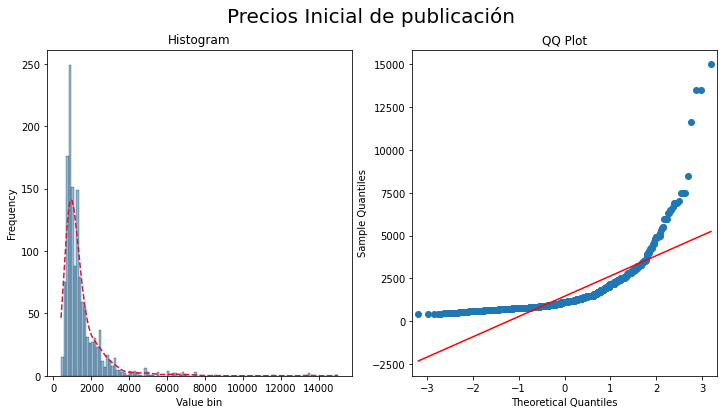

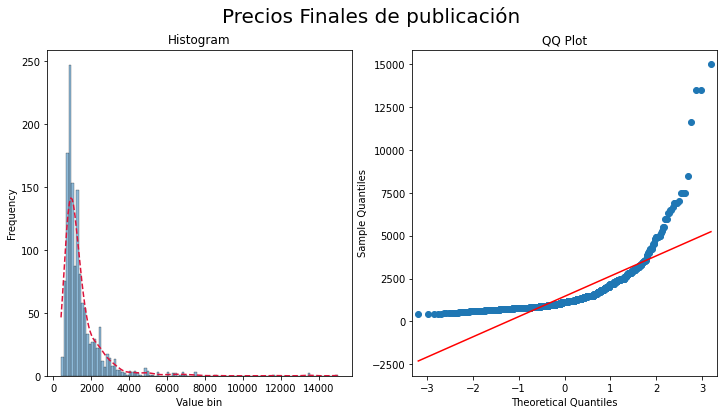

In [22]:
visualizeNorm('Precios Inicial de publicación', dataset.price_initial)
visualizeNorm('Precios Finales de publicación', dataset.price)

En los gráficos se aprecia que las variables no siguen una distribución normal, aún así aplicando el test Shapiro-Wilk:

In [23]:
showShapiroWilkResult(dataset.price_initial)
showShapiroWilkResult(dataset.price)

Statistics=0.601, p=0.000
Non Gaussian Distribution

Statistics=0.602, p=0.000
Non Gaussian Distribution



Verificamos que no se comportan como distribuciones normales.

In [24]:
print(len(dataset.price_initial))
print(len(dataset.price))

1406
1406


Si aplicamos el _teorema central del límite_ el conjunto de datos es suficientemente grande (N > 30) para considerar que las medias muestrales siguen una distribución normal.

Para comprobar si existe alguna diferencia entre el antes y el después planteamos el siguiente contraste de hipótesis de dos muestras dependientes sobre la diferencia de medias:


H0 : _μ1_ − _μ2_ = 0

H1 : _μ1_ − _μ2_ <> 0


Donde _μ1_ es la media del precio inicial y μ2 es la media del precio final.

In [25]:
ttest_rel(dataset.price_initial,  dataset.price, alternative='two-sided')

Ttest_relResult(statistic=1.0668233932802025, pvalue=0.28623487010260895)

Debido a que el p-value es mayor que el nivel de significancia de 0.05 fijado no podemos rechazar la hipótesis nula, por lo que podemos concluir que las bajadas de precios recogidas no afectan de forma significativa a la media de los precios.

### Conclusiones finales

A partir de aquí podemos concluir que si eres un usuario que busca un contrato de alquiler y queremos ahorrar no tenemos que preocuparnos por si el anuncio es de inmobiliaria o de un particular, ya que los precios no son significativamente diferentes. De igual forma pasa con la promoción de anuncios, las personas que utilizan estos mecanismos no trasladan el coste al precio del alquiler, puesto que las medias no tienen diferencias significativas.

Por último, vemos que en la evolución de los precios no hay diferencias en intervalos cortos de días, por lo que esperar a que el propietario realize una bajada en el precio no es una buena estrategia, ya que estadísticamente se ve que las bajadas no afectan a la media de los precios, por tanto no se producen de forma muy habitual o no en una cuantía significativa.